In [1]:
%pylab inline
import skimage

Populating the interactive namespace from numpy and matplotlib


In [2]:
import imageio

In [797]:
filename='../stack.avi_reg.avi';
vid = imageio.get_reader(filename, 'ffmpeg')

In [693]:
nframe=0
frames=[]
for image in vid.iter_data():
    data=np.mean(image,2)
    frames += [data]
    print(image.mean(),nframe)
    nframe +=1
frames=np.array( frames)

2.873278045654297 0
3.482094573974609 1
3.6127639770507813 2
3.5744087219238283 3
3.4595489501953125 4
3.2261863708496095 5
3.784941864013672 6
3.654694366455078 7
4.0783843994140625 8
3.9709732055664064 9
3.9963783264160155 10
4.03089599609375 11
4.199433135986328 12
4.276152801513672 13
4.130026245117188 14
3.6061630249023438 15
3.804984283447266 16
3.709858703613281 17
3.3028228759765623 18
3.642469024658203 19
3.7679847717285155 20
3.74808349609375 21
3.4940887451171876 22
3.5746315002441404 23
3.737864685058594 24
2.902898406982422 25
2.7123260498046875 26


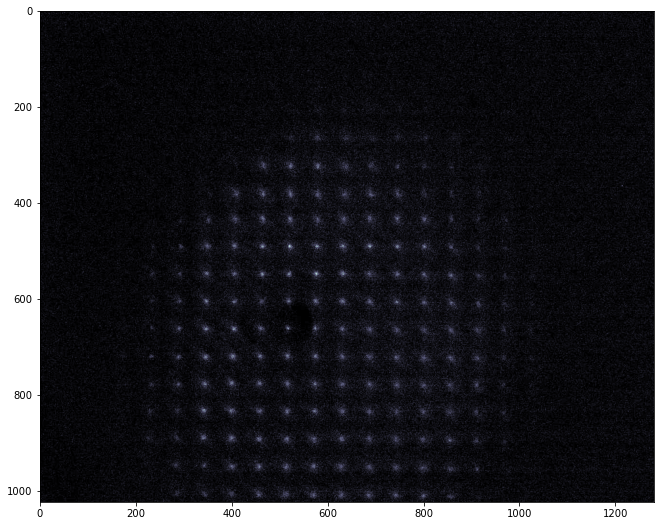

In [694]:
plt.figure(figsize=(11,11))
plt.imshow( frames[1], cmap='bone')

In [713]:
frames[frames<15]=0

In [714]:
np.min(frames[frames>10])

15.0

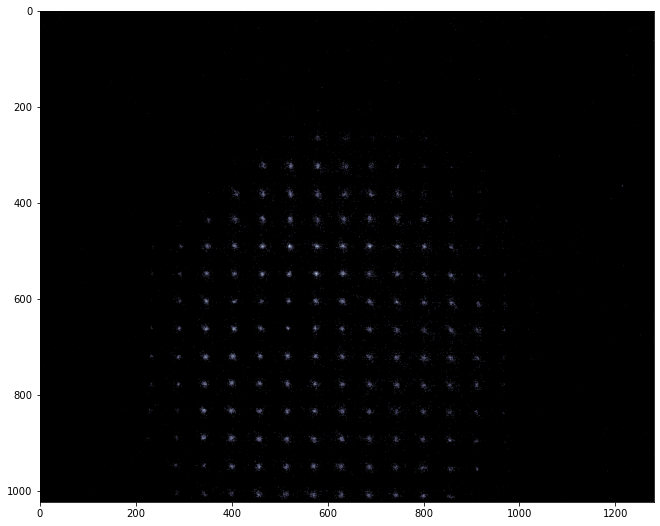

In [715]:
plt.figure(figsize=(11,11))
plt.imshow( frames[1], cmap='bone')

In [14]:
np.array(frames).shape

(27, 1024, 1280)

In [29]:
np.argmax( frames[1] )

702015

In [44]:
coords=np.unravel_index( np.argmax( frames[1] ), frames[1].shape ) # y,x

IndexError: tuple index out of range

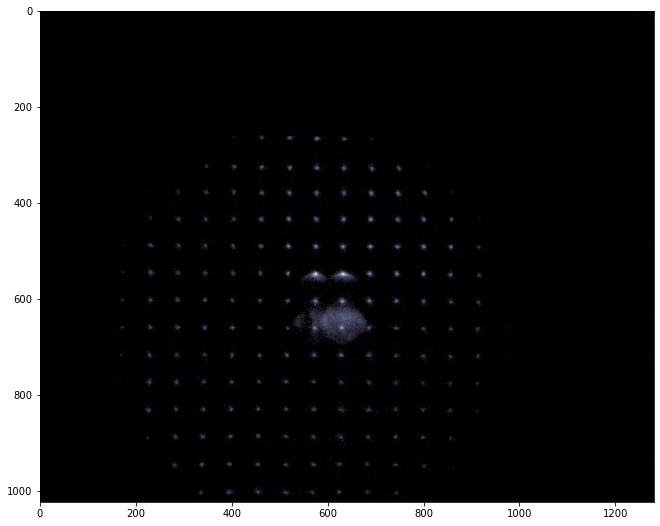

In [793]:
plt.figure(figsize=(11,11))
plt.imshow( frames[16], cmap='bone')

plt.scatter( coords[16], coords[0], s=3, color='r') # x,y

In [38]:
coords

(548, 575)

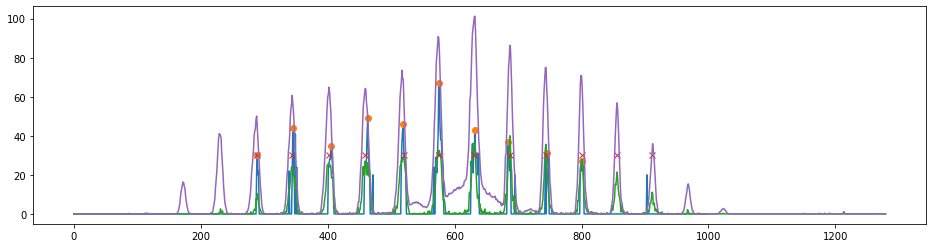

In [120]:
plt.figure(figsize=(16,4))
plt.plot( frames[1,548,0:1000])


xsig=np.mean( frames[1], 0)

#Normalize
xsig /= xsig.max()
xsig *= 40

import scipy.signal
peaks=scipy.signal.find_peaks(frames[1,548,:900], distance=30)[0]

plt.plot( peaks, frames[1,548,peaks], 'o' )
plt.plot( xsig, '-' )

peaks2=scipy.signal.find_peaks(xsig, distance=30, height=10)[0]

plt.plot( peaks2, peaks2*0+30, 'x')

plt.plot( xsigA*20 )

In [116]:
xsigA=np.mean( np.mean( frames, 0), 0 )
#peaks2=scipy.signal.find_peaks(xsig, distance=30, height=10)[0]


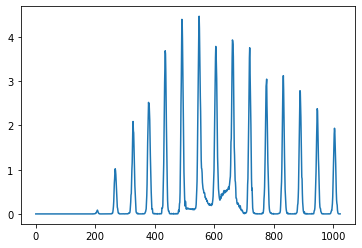

In [132]:
xsigA1=np.mean( np.mean( frames, 0), 1 )
peaks21=scipy.signal.find_peaks(xsigA1, distance=30, height=1)[0]
np.mean( np.diff(peaks21) )

56.69230769230769

In [107]:
peaks

array([289, 345, 405, 463, 519, 575, 632, 684, 746, 801])

In [110]:
np.mean( np.diff(peaks) ), np.mean( np.diff(peaks2) )

(56.888888888888886, 56.54545454545455)

In [139]:
spacing=56.7

In [271]:
import cupy, cupyx

In [272]:
import cupyx.scipy.signal

In [277]:
frames[4].shape

(1024, 1280)

In [284]:
# %what=cupyx.scipy.signal.convolve2d( cupy.array(frames[4]), cupy.array(box1) )
# import numba

UsageError: Line magic function `%what=cupyx.scipy.signal.convolve2d(` not found.


In [778]:
BOX_THRESHOLD = 100 # For binarization of lenslet. TODO: what should threshold be?

corners_x=np.arange( int( frames[0].shape[1]//spacing ) ) * spacing
corners_y=np.arange( int( frames[0].shape[0]//spacing ) ) * spacing

# Find the brightest pixel across all frames. Assume it's a good spot (shift phase of spot array)
coordsA=np.unravel_index( np.argmax( np.mean(frames,0) ), frames[0].shape )

corners_x = np.array( corners_x + coordsA[1] % spacing - spacing//2 , dtype='int')
corners_y = np.array( corners_y + coordsA[0] % spacing - spacing//2 , dtype='int')

In [779]:
opts_all=np.zeros( (frames.shape[0],3) )
boxes_all = np.zeros( (frames.shape[0],corners_y.size, corners_x.size))

In [780]:
stride=int( np.ceil(spacing) )
box1=np.ones( (stride,stride) )

box_sums = np.zeros( (corners_y.size, corners_x.size) )

X,Y=np.meshgrid( np.arange(box_sums.shape[1]), np.arange(box_sums.shape[0]) )

def circle(cx,cy,rad):
    X,Y=np.meshgrid( np.arange(box_sums.shape[1]), np.arange(box_sums.shape[0]) )
    r=np.sqrt((X-cx-0.0*np.sign(X))**2+(Y-cy-0.0*np.sign(Y))**2) # 0.5 fudge
    #r=np.sqrt((X-cx)**2+(Y-cy)**2)
    #rad=7.27 # IGNORE RADIUS. Fixed pupil size
    result=(r<rad)*1.0
    return result

def circle_err(p):
    ssq=np.sum( (circle(*p)-desired) **2 )
    #print( p, ssq)
    return ssq

import scipy.optimize

In [781]:
x:x+stride

In [782]:
box1=frames[nframe,y:y+stride,x:x+stride]

In [783]:
for nframe in np.arange(frames.shape[0]):

    #convs=scipy.signal.convolve2d( frames[nframe], box1)

    for nx,x in enumerate(corners_x):
        for ny,y in enumerate(corners_y):
            box_sums[ny,nx]=np.sum( frames[nframe,y:y+stride,x:x+stride] )
            #box_sums[ny,nx]=convs[int(y+spacing),int(x+spacing)] # extract from convs
            box1=frames[nframe,y:y+stride,x:x+stride]
            #if box1.size>0:
            #    box_sums[ny,nx]=np.max( box1 )
            #else:
            #    box_sums[ny,nx]=0
            
    boxes_all[nframe]=box_sums

    desired = (box_sums > BOX_THRESHOLD)*1.0 # binarize 

    guess =[ np.sum( desired*X / np.sum(desired ) ) ,
            np.sum( desired*Y / np.sum(desired ) ),
            np.sqrt( np.sum(desired) / np. pi ) ]

    opt1=scipy.optimize.minimize( circle_err, guess, method='Nelder-Mead')
    print(nframe,opt1)     
    
    opts_all[nframe]=opt1.x

0  final_simplex: (array([[ 9.76911992, 11.7568294 ,  7.11763367],
       [ 9.76908178, 11.75679658,  7.11763443],
       [ 9.76915271, 11.75675419,  7.11763679],
       [ 9.76913173, 11.75675576,  7.11762511]]), array([11., 11., 11., 11.]))
           fun: 11.0
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 22
        status: 0
       success: True
             x: array([ 9.76911992, 11.7568294 ,  7.11763367])
1  final_simplex: (array([[10.64775541, 11.06876603,  7.54445214],
       [10.6478141 , 11.06877958,  7.54444328],
       [10.64778746, 11.06880176,  7.54445325],
       [10.64778433, 11.06875353,  7.54445884]]), array([16., 16., 16., 16.]))
           fun: 16.0
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 29
        status: 0
       success: True
             x: array([10.64775541, 11.06876603,  7.54445214])
2  final_simplex: (array([[11.07387255, 10.24348039,  7.54003548],
       [11.0739

18  final_simplex: (array([[10.06046817, 10.79113125,  7.26976015],
       [10.06040316, 10.79109354,  7.26972808],
       [10.06046592, 10.79120498,  7.26973192],
       [10.06046201, 10.79115812,  7.26970997]]), array([3., 3., 3., 3.]))
           fun: 3.0
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 24
        status: 0
       success: True
             x: array([10.06046817, 10.79113125,  7.26976015])
19  final_simplex: (array([[ 9.28484848, 10.78787879,  7.24714642],
       [ 9.28483375, 10.78791277,  7.24713839],
       [ 9.28487708, 10.7879067 ,  7.24711711],
       [ 9.28484511, 10.7879366 ,  7.24715049]]), array([2., 2., 2., 2.]))
           fun: 2.0
       message: 'Optimization terminated successfully.'
          nfev: 79
           nit: 24
        status: 0
       success: True
             x: array([ 9.28484848, 10.78787879,  7.24714642])
20  final_simplex: (array([[ 9.34846278, 11.11471786,  7.3198474 ],
       [ 9.34848685, 1

(-0.5, 21.5, 17.5, -0.5)

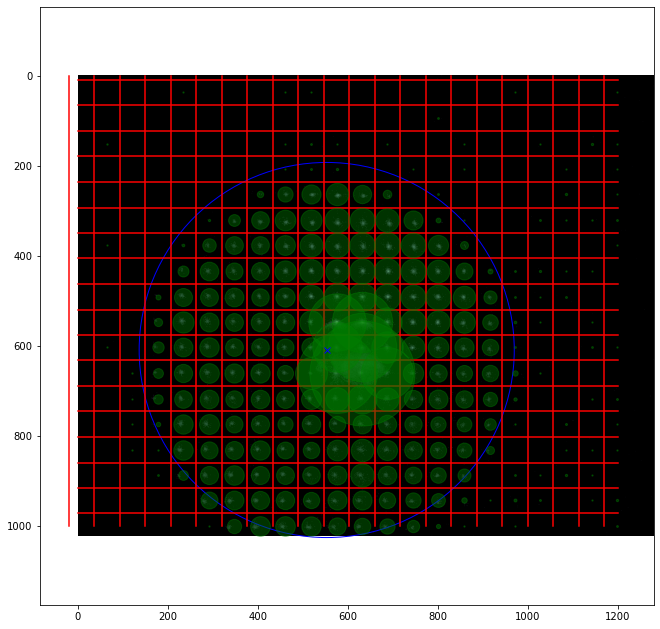

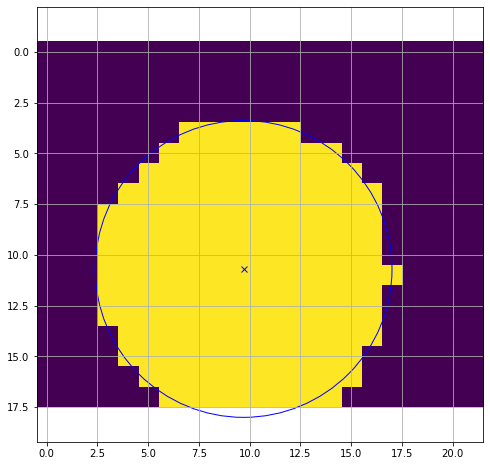

In [792]:
frame_show=16

plt.figure(figsize=(11,11))
plt.imshow( frames[frame_show], cmap='bone')

#plt.scatter( coordsA[1], coordsA[0], s=3, color='r') # x,y

for ncorner,xc1 in enumerate(corners_x):
    plt.plot( [xc1,xc1], [0,1000], 'r-')
    
for ncorner,yc1 in enumerate(corners_y):
    plt.plot( [0,1200], [yc1,yc1], 'r-')
    
for nx,x in enumerate(corners_x):
    for ny,y in enumerate(corners_y):
        plt.plot(x+spacing//2,y+spacing//2, 'go', ms=np.sqrt(boxes_all[frame_show,ny,nx])/3, alpha=0.4 )


import matplotlib.patches as mpatches   
opt1=opts_all[frame_show]
cx_pix,cy_pix=(opt1[0]*stride, opt1[1]*stride)
circ=mpatches.Circle( (cx_pix, cy_pix), opt1[2]*stride, color="none",ec='blue')
ax=plt.gca()
ax.add_artist(circ)

plt.plot( cx_pix, cy_pix, 'bx' )
plt.axis('equal')

plt.figure(figsize=(8,8))
plt.imshow(boxes_all[frame_show]>BOX_THRESHOLD)
circ=mpatches.Circle( (opt1[0], opt1[1]), opt1[2], color="none",ec='blue')
ax=plt.gca()
ax.add_artist(circ)
plt.plot( opt1[0], opt1[1], 'bx' )
plt.grid()
plt.axis('equal')

In [785]:
opts_all

array([[ 9.76911992, 11.7568294 ,  7.11763367],
       [10.64775541, 11.06876603,  7.54445214],
       [11.07387255, 10.24348039,  7.54003548],
       [11.45953265, 10.17783964,  7.39824225],
       [11.70003743, 10.9110334 ,  7.2961576 ],
       [11.63690476, 10.81547619,  7.31273279],
       [10.55310329, 10.37247753,  7.55457907],
       [10.4821831 , 10.29576191,  7.48413269],
       [ 9.99579613, 10.60994162,  7.67872562],
       [10.34777083, 11.09199554,  7.62614342],
       [10.07951389, 10.87881944,  7.64036067],
       [10.20471532, 10.7014912 ,  7.65540487],
       [ 9.06351852, 10.80739133,  7.54223885],
       [ 9.22129139, 10.7465572 ,  7.52038869],
       [ 8.91497093, 11.07550872,  7.49176798],
       [ 9.12251693, 10.86140286,  7.27158999],
       [ 9.70258585, 10.69678523,  7.31433867],
       [10.15484125, 10.99679111,  7.42423538],
       [10.06046817, 10.79113125,  7.26976015],
       [ 9.28484848, 10.78787879,  7.24714642],
       [ 9.34846278, 11.11471786,  7.319

In [745]:
np.mean(opts_all,0)

array([ 9.93290634, 10.77078897,  7.27058089])

In [746]:
opts_all

array([[ 9.90625616, 11.6349734 ,  6.80754719],
       [10.74257192, 11.01758433,  7.40922024],
       [11.04455368, 10.13679806,  7.5135502 ],
       [11.54118217, 10.66365472,  7.32305762],
       [11.71900852, 10.90518179,  7.27782623],
       [11.67194777, 10.74139083,  7.32637827],
       [10.55310329, 10.37247753,  7.55457907],
       [10.4821831 , 10.29576191,  7.48413269],
       [10.0891527 , 10.77607076,  7.55358408],
       [10.40816758, 10.89790469,  7.43716507],
       [10.16380221, 10.83028539,  7.55124053],
       [10.05655261, 10.86767342,  7.59289836],
       [ 9.18484043, 10.78973181,  7.50662837],
       [ 9.26478106, 10.87895608,  7.34461315],
       [ 9.14275769, 10.96230101,  7.421643  ],
       [ 9.1729609 , 10.99469027,  7.32592816],
       [ 9.76474603, 10.76871681,  7.4128972 ],
       [10.21587456, 10.64628526,  7.2385061 ],
       [ 9.92770681, 10.89927855,  7.30656072],
       [ 9.37654321, 10.82098765,  7.18096105],
       [ 9.43018716, 10.85099488,  7.112

In [747]:
np.round(opts_all)

array([[10., 12.,  7.],
       [11., 11.,  7.],
       [11., 10.,  8.],
       [12., 11.,  7.],
       [12., 11.,  7.],
       [12., 11.,  7.],
       [11., 10.,  8.],
       [10., 10.,  7.],
       [10., 11.,  8.],
       [10., 11.,  7.],
       [10., 11.,  8.],
       [10., 11.,  8.],
       [ 9., 11.,  8.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [10., 11.,  7.],
       [10., 11.,  7.],
       [10., 11.,  7.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [ 9., 11.,  7.],
       [10., 11.,  7.],
       [ 7., 10.,  5.]])

In [796]:
imageio.get_writer?

In [749]:
# WRITE DATA
middle_box=np.array(np.round( np.array(frames[0].shape) / stride / 2), dtype='int' )

filename='../stack_centered.avi'
vid = imageio.get_writer(filename, 'ffmpeg',fps=7)

outframes=frames*0

for nframe,frame1 in enumerate(frames):
    opts1=opts_all[nframe]
    opts1r=np.array(np.round(opts1),dtype='int') # Round to nearest (for center, mainly)
    
    deltay=middle_box[0]-opts1r[1] # Y coord. opts is (x,y)
    deltax=middle_box[1]-opts1r[0] # X coord
    
    frame1x = np.array( frame1, dtype='uint8')
    frame1x = np.roll(frame1x,deltay*stride,0) # Y axis 
    frame1x = np.roll(frame1x,deltax*stride,1) # X axis
    
    outframes[nframe]=frame1x
    
    data_rgb=np.stack([frame1x] * 3, axis=-1)
    vid.append_data(data_rgb)

vid.close()

In [787]:
FPS=7


#gray_frames_as_rgb = np.stack([outframes.astype('uint8')] * 1, axis=-1)
#gray_frames_as_rgb = outframes.astype('uint8')
#imageio.imwrite(filename, gray_frames_as_rgb, fps=FPS)


In [647]:
outframes.shape

(27, 1024, 1280)

In [786]:
#frames_new=imageio.imread('../stack.avi_reg.avi')
#vid.append_data?

In [367]:
print( )
print( np.sum( desired*Y / np.sum(desired ) ) )

11.618181818181817
10.89090909090909


In [630]:
pwd

'/home/dcoates/projects/yoon/nextwave'

In [372]:
guess

[11.618181818181817, 10.89090909090909, 7.247146419131151]

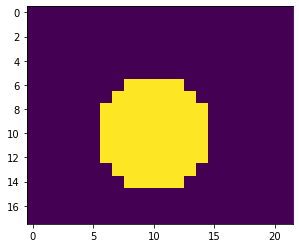

In [354]:
plt.imshow( circle(10,10,4.5) )

 final_simplex: (array([[11.74878505, 11.0534189 ,  7.24618967],
       [11.7487959 , 11.05339827,  7.24615983],
       [11.74876861, 11.05343267,  7.24614238],
       [11.74874597, 11.05339163,  7.24611935]]), array([7., 7., 7., 7.]))
           fun: 7.0
       message: 'Optimization terminated successfully.'
          nfev: 114
           nit: 44
        status: 0
       success: True
             x: array([11.74878505, 11.0534189 ,  7.24618967])


array([11.74878505, 11.0534189 ,  7.24618967])

In [385]:
import scipy.optimize
scipy.optimize.minimize( circle_err, guess, method='Nelder-Mead')

 final_simplex: (array([[11.67936553, 11.05162563,  7.29705443],
       [11.67935047, 11.05158714,  7.29699792],
       [11.67932638, 11.0515491 ,  7.29702193],
       [11.67935873, 11.05154304,  7.29700606]]), array([6., 6., 6., 6.]))
           fun: 6.0
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 22
        status: 0
       success: True
             x: array([11.67936553, 11.05162563,  7.29705443])

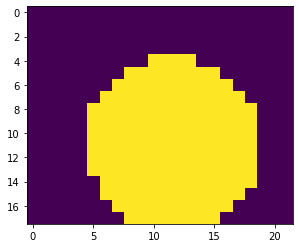

In [375]:
plt.imshow( circle( *guess) )

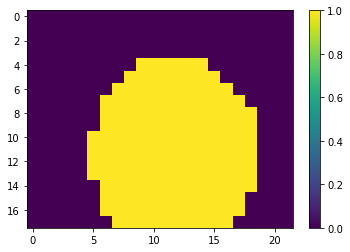

In [332]:
plt.imshow( box_sums>100); colorbar()

In [290]:
convs[int(corners_y+spacing),int(corners_y+spacing)]

TypeError: only size-1 arrays can be converted to Python scalars

In [204]:
X,Y=np.meshgrid(corners_x,corners_y)

/tmp/ipykernel_1063485/2627770169.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10( convs[Y,X]) )


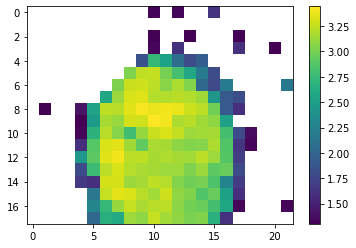

In [238]:
plt.imshow(np.log10( convs[Y,X]) )
plt.colorbar()

In [163]:
spacing

56.7

In [319]:
x=np.linspace(0,5); y=np.linspace(0,5)+10

In [320]:

import pandas as pd

In [326]:
df=pd.DataFrame({'x':x, 'y':y})
df.to_csv('wow.csv',index=None)

In [325]:
pwd

'/home/dcoates/projects/yoon/nextwave'